# Análisis Exploratorio de Datos(EDA): En este proceso analizamos y visualizamos como estan estructurados las tablas para encontrar anomalias,nulos y patrones las cuales tendremos que tener en cuenta para mejorar nuestra calidad de los datos

## carga de librerias y Archivos

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud
import re

In [83]:
df_games = pd.read_parquet("Datasets_finales/games_steam.parquet")
df_items = pd.read_parquet("Datasets_finales/user_items.parquet")
df_reviews = pd.read_parquet("Datasets_endpoints/user_reviews_sentiment.parquet")

### Funciones

![Pesos de Valoracion](_src/Informacion_pesos_valoracion.jpg)

In [84]:
def Valoraciones(Recobuenas,Recomalas,ComBuenas,ComNeutra,ComMalas):
    try:
        Valoracionfinal = (Recobuenas * 3 + Recomalas * -1 + ComBuenas * 2 + ComNeutra * 0 + ComMalas * -1)/(Recobuenas + Recomalas)
    except ZeroDivisionError:
        return 0
    else:
        return round(Valoracionfinal,1) 

In [85]:
def caracteres_especiales(texto):
    """ 
    Recibe un texto y le elimina los caracteres especiales
    
    ejemplo:
    recibe : fut\nbol
    devuelve: futbol
    
    """
    return re.sub(r'[^a-zA-Z0-9\n\s]', '', texto)

In [86]:
def str_to_float(valor):
    # usando excepciones vamos a hacer un try para que convierta el valor ingresado en la funcion en un float
    try:
        return float(valor)
    
    # si falla en convertirlo va a saltar a la excepcion, para TypeError son los nulos y para ValueError son los que no se pueden convertir en float porque son letras
    except (TypeError,ValueError):
        # en esta condicional hacemos que los que sean gratis sean 0
        if valor == "free":
            return 0
        # y si no cumple nada es porque es nulo o no es free ,entonces lo guarda como -1 para poder distinguierlo posteriormente en un grafico
        else:
            return -1

In [87]:
# convierte el valor en lista solamente si es un Array,sino devuelve el valor
def conversor_a_lista(valor):
    if isinstance(valor,np.ndarray):
        return valor.tolist()
    else:
        return valor

## Proceso de EDA a realizar:
* Estadisticas Descriptivas para mejorar la comprension de datos tenemos
* Limpieza y Normalizacion de los Datos
* Visualizacion con graficas 
* Seleccion de columnas a utilizar para el modelo de machine learning
* Exportacion de los archivos

## ACLARACIONES IMPORTANTES!!
El análisis exploratorio de datos (EDA) puede revelar aspectos similares o diferentes a los observados en los endpoints creados para las consultas de la API. El EDA se enfoca en una exploración profunda de los datos, permitiendo identificar anomalías en las tablas y determinar qué datos son más adecuados para el sistema de recomendación. Aunque es probable que algunos pasos se repitan en el proceso de diseño de endpoints, no todos se aplican, ya que el enfoque de los endpoints está más orientado hacia la optimización y la calidad de los datos para las consultas.

### Visualizaciones de Estadisticas

In [88]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32133 entries, 0 to 32132
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   genres        28851 non-null  object        
 1   app_name      32133 non-null  object        
 2   release_date  29782 non-null  datetime64[ns]
 3   price         30757 non-null  object        
 4   item_id       32133 non-null  int32         
 5   developer     28836 non-null  object        
dtypes: datetime64[ns](1), int32(1), object(4)
memory usage: 1.3+ MB


In [89]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110796 entries, 0 to 5110795
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   item_id           object 
 1   playtime_forever  float64
 2   user_id           object 
 3   items_count       int64  
 4   steam_id          object 
dtypes: float64(1), int64(1), object(3)
memory usage: 195.0+ MB


In [90]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58458 entries, 0 to 58457
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             58458 non-null  object
 1   item_id             58430 non-null  object
 2   recommend           58430 non-null  object
 3   sentiment_analysis  58458 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.8+ MB


#### luego de esta visualizacion basica de estructura podemos sacar las siguiente conclusiones 
* hay nulos en las tablas games,reviews y seguramente tambien en items
* las columnas **item_id** y **user_id** son importantes ya que son coincidentes para la union de las tablas y seguramente tenga correlativas 

### Limpieza y Normalizacion de los datos

#### Tabla **Games**

* hacemos una visualizacion de los datos

In [91]:
df_games.head()

,genres,app_name,release_date,price,item_id,developer
0,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,2018-01-04,4.99,761140,Kotoshiro
1,"[Free to Play, Indie, RPG, Strategy]",Ironbound,2018-01-04,free,643980,Secret Level SRL
2,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,2017-07-24,free,670290,Poolians.com
3,"[Action, Adventure, Casual]",弹炸人2222,2017-12-07,0.99,767400,彼岸领域
4,None,Log Challenge,NaT,2.99,773570,None


* buscamos datos duplicados

In [92]:
df_games[df_games.duplicated(subset=["app_name","release_date","developer"],keep=False)]

,genres,app_name,release_date,price,item_id,developer
1067,"[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,2012-09-07,19.99,200260,"Rocksteady Studios,Feral Interactive (Mac)"
1507,"[Adventure, Casual, Indie]",The Dream Machine: Chapter 4,2013-08-05,4.99,93304,Cockroach Inc.
1508,"[Adventure, Casual, Indie]",The Dream Machine: Chapter 4,2013-08-05,None,94304,Cockroach Inc.
10348,None,Escape Room,NaT,0.99,654070,None
13419,None,Escape Room,NaT,free,758210,None
13892,[Action],Wolfenstein II: The New Colossus,2017-10-26,59.99,612880,Machine Games
14571,[Action],Wolfenstein II: The New Colossus,2017-10-26,59.99,612880,Machine Games
30176,[Action],Aliens: Colonial Marines - Reconnaissance Pack,2013-05-07,None,224850,Gearbox Software
30177,[Action],Aliens: Colonial Marines - Reconnaissance Pack,2013-05-07,29.99,219441,Gearbox Software
30959,"[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,2012-09-07,19.99,200260,"Rocksteady Studios,Feral Interactive (Mac)"


* anteriormente podemos ver que hay Nulos en precio pero varian en algunos está en la segunda mencion del mismo juego y en otro está primero, a lo que vamos a ordenarlo por precio y que los nulos se vayan a lo ultimo

In [93]:
df_games.sort_values(by="price",na_position="last",inplace=True)

In [94]:
df_games[df_games.duplicated(subset=["app_name","release_date","developer"],keep=False)]

,genres,app_name,release_date,price,item_id,developer
10348,None,Escape Room,NaT,0.99,654070,None
30959,"[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,2012-09-07,19.99,200260,"Rocksteady Studios,Feral Interactive (Mac)"
1067,"[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,2012-09-07,19.99,200260,"Rocksteady Studios,Feral Interactive (Mac)"
30177,[Action],Aliens: Colonial Marines - Reconnaissance Pack,2013-05-07,29.99,219441,Gearbox Software
1507,"[Adventure, Casual, Indie]",The Dream Machine: Chapter 4,2013-08-05,4.99,93304,Cockroach Inc.
14571,[Action],Wolfenstein II: The New Colossus,2017-10-26,59.99,612880,Machine Games
13892,[Action],Wolfenstein II: The New Colossus,2017-10-26,59.99,612880,Machine Games
13419,None,Escape Room,NaT,free,758210,None
1508,"[Adventure, Casual, Indie]",The Dream Machine: Chapter 4,2013-08-05,None,94304,Cockroach Inc.
30176,[Action],Aliens: Colonial Marines - Reconnaissance Pack,2013-05-07,None,224850,Gearbox Software


* Limpiamos los duplicados , ordenamos por el index y verificamos si quedaron duplicados

In [95]:
df_games.drop_duplicates(subset=["app_name","release_date","developer"],keep="first",inplace=True)
df_games.sort_index(inplace=True)
df_games[df_games.duplicated(subset=["app_name","release_date","developer"],keep=False)]

,genres,app_name,release_date,price,item_id,developer


* empezamos a hacer la busqueda de nulos

In [96]:
df_games[df_games["developer"].isna()]

,genres,app_name,release_date,price,item_id,developer
4,None,Log Challenge,NaT,2.99,773570,None
11,None,Icarus Six Sixty Six,NaT,free,724910,None
19,None,After Life VR,NaT,4.99,772590,None
20,None,Kitty Hawk,NaT,2.99,640250,None
22,None,Mortars VR,NaT,0.99,711440,None
...,...,...,...,...,...,...
32116,None,Robotpencil Presents: Exercise: Brushwork,2018-01-03,3.99,775640,None
32117,None,Robotpencil Presents: Creative Composition,2018-01-03,3.99,777930,None
32118,None,The Gamble House,2016-11-19,4.99,775370,None
32119,None,Kalen Chock Presents: 2017 Free Tutorial,2018-01-03,free,777950,None


* como podemos ver tenemos nulos en genres,developer y release_date, como genres y developer son textos podemos ponerles Sin dato, y a release_date luego transformamos en año ya que luego si tendriamos que hacer una grafica

In [97]:
df_games["genres"] = df_games["genres"].fillna("sin dato")
df_games["developer"] = df_games["developer"].fillna("sin dato")

* ahora chequeamos el de price ya que en si tiene que ser numerico para posteriomente compararlo

In [98]:
df_games[df_games["price"].isna()]

,genres,app_name,release_date,price,item_id,developer
9,"[Casual, Indie, Racing, Simulation]",Race,2018-01-04,None,768800,RewindApp
10,"[Action, Indie, Simulation, Early Access]",Uncanny Islands,NaT,None,768570,Qucheza
31,"[Casual, Indie, Strategy]",Lost Cities,2018-01-01,None,520680,BlueLine Games
32,[Action],Twisted Enhanced Edition,2018-01-01,None,690410,Games by Brundle
34,"[Action, Casual, Indie, Massively Multiplayer,...",Tactics Forever,2018-01-01,None,413120,ProjectorGames
...,...,...,...,...,...,...
32097,"[Action, Indie]",Infinos Gaiden,2018-01-19,None,771070,Picorinne Soft
32109,[Sports],International Online Soccer,2002-01-01,None,90007,I.O.S. Team
32121,"[Casual, Indie, Simulation, Sports, Early Access]",Cricket Club,NaT,None,772180,VersoVR
32123,"[Action, Adventure, Indie]",The spy who shot me™,2018-10-01,None,771810,Retro Army Limited


* convertimos los que tiene el price en nulos y str que no sean "free" en -1, a los free los dejamos en 0, y los float en formato str lo volvemos a float nuevamente

In [99]:
df_games["price"] = df_games["price"].apply(str_to_float)

* vamos a ver cuales están como -1

In [100]:
df_games[df_games["price"] == -1].head(5)

,genres,app_name,release_date,price,item_id,developer
9,"[Casual, Indie, Racing, Simulation]",Race,2018-01-04,-1.0,768800,RewindApp
10,"[Action, Indie, Simulation, Early Access]",Uncanny Islands,NaT,-1.0,768570,Qucheza
31,"[Casual, Indie, Strategy]",Lost Cities,2018-01-01,-1.0,520680,BlueLine Games
32,[Action],Twisted Enhanced Edition,2018-01-01,-1.0,690410,Games by Brundle
34,"[Action, Casual, Indie, Massively Multiplayer,...",Tactics Forever,2018-01-01,-1.0,413120,ProjectorGames


* vamos a sacar el año del release_date y luego borramos el release_date dejando solo el año

In [101]:
df_games["año"] = df_games["release_date"].dt.year
df_games["año"] = df_games["año"].fillna(0)
df_games["año"] = df_games["año"].astype(int)
df_games.drop("release_date",axis=1,inplace=True)

* convertimos los app_name y developer en minusculas 

In [102]:
df_games["developer"] = df_games["developer"].str.lower()
df_games["app_name"] = df_games["app_name"].str.lower()

In [103]:
df_games.reset_index(drop=False)
df_games.head(5)

,genres,app_name,price,item_id,developer,año
0,"[Action, Casual, Indie, Simulation, Strategy]",lost summoner kitty,4.99,761140,kotoshiro,2018
1,"[Free to Play, Indie, RPG, Strategy]",ironbound,0.00,643980,secret level srl,2018
2,"[Casual, Free to Play, Indie, Simulation, Sports]",real pool 3d - poolians,0.00,670290,poolians.com,2017
3,"[Action, Adventure, Casual]",弹炸人2222,0.99,767400,彼岸领域,2017
4,sin dato,log challenge,2.99,773570,sin dato,0


#### tabla de **Items**

* hacemos una visualizacion de los datos

In [104]:
df_items.head()

,item_id,playtime_forever,user_id,items_count,steam_id
0,10,6.0,76561197970982479,277,76561197970982479
1,20,0.0,76561197970982479,277,76561197970982479
2,30,7.0,76561197970982479,277,76561197970982479
3,40,0.0,76561197970982479,277,76561197970982479
4,50,0.0,76561197970982479,277,76561197970982479


* buscamos duplicados, mediante user_id y item_id

In [105]:
df_items[df_items.duplicated(subset=["item_id","user_id"],keep=False)]

,item_id,playtime_forever,user_id,items_count,steam_id


* perfecto, no hay duplicados, ahora procedemos a buscar nulos. es importante que no haya nulos en item_id y user_id

In [106]:
df_items[df_items["item_id"].isna()]

,item_id,playtime_forever,user_id,items_count,steam_id
3733,None,NaN,Wackky,0,76561198039117046
3849,None,NaN,76561198079601835,0,76561198079601835
6019,None,NaN,hellom8o,0,76561198117222320
6523,None,NaN,starkillershadow553,0,76561198059648579
7237,None,NaN,darkenkane,0,76561198058876001
...,...,...,...,...,...
5110251,None,NaN,76561198316380182,0,76561198316380182
5110252,None,NaN,76561198316970597,0,76561198316970597
5110253,None,NaN,76561198318100691,0,76561198318100691
5110787,None,NaN,XxLaughingJackClown77xX,0,76561198328759259


* analizando anteriormente los nulos, vemos que hay item_id nulos al igual que playtime y items_count en 0. como conclusion podemos decir que no nos sirven ya que no aportan ningun dato que podamos usar en graficas.
* procedemos a borrar todos las filas que tengan nulos en item_id y reseteamos el index 

In [107]:
df_items = df_items.dropna(subset=["item_id"]).reset_index(drop=True)
df_items[df_items["item_id"].isna()]

,item_id,playtime_forever,user_id,items_count,steam_id


* hacemos una vision de playtime_forever que estan en 0 y vemos que hay 1.847.730 de filas , podriamos borrarlas pero estariamos borrando informacion importante para el modelo de recomendacion ya que se podria considerar que lo compraron pero no lo jugaron al final.

In [108]:
df_items[df_items["playtime_forever"] == 0].head(5)

,item_id,playtime_forever,user_id,items_count,steam_id
1,20,0.0,76561197970982479,277,76561197970982479
3,40,0.0,76561197970982479,277,76561197970982479
4,50,0.0,76561197970982479,277,76561197970982479
5,60,0.0,76561197970982479,277,76561197970982479
6,70,0.0,76561197970982479,277,76561197970982479


* pasamos a minusculas los user_id y en int a los item_id

In [109]:
df_items["user_id"] = df_items["user_id"].str.lower()
df_items["item_id"] = df_items["item_id"].astype(int)

#### Tabla **Reviews**

* Hacemos una visualizacion de los datos

In [110]:
df_reviews

,user_id,item_id,recommend,sentiment_analysis
0,76561197970982479,1250,True,2
1,76561197970982479,22200,True,2
2,76561197970982479,43110,True,2
3,js41637,251610,True,2
4,js41637,227300,True,2
...,...,...,...,...
58453,76561198312638244,70,True,2
58454,76561198312638244,362890,True,2
58455,LydiaMorley,273110,True,2
58456,LydiaMorley,730,True,2


* Buscamos duplicados basandonos en user_id y item_id

In [111]:
df_reviews[df_reviews.duplicated(subset=["user_id","item_id"],keep=False)]

,user_id,item_id,recommend,sentiment_analysis


* perfecto no hay user_id y item_id duplicados, ahora empezamos la busqueda de nulos

In [112]:
df_reviews[df_reviews["item_id"].isna()].head(5)

,user_id,item_id,recommend,sentiment_analysis
137,gdxsd,None,None,1
177,76561198094224872,None,None,1
2558,76561198021575394,None,None,1
9956,cmuir37,None,None,1
13528,Jaysteeny,None,None,1


* hay item_id nulos, a lo que vamos a procedar a borrarlos

In [113]:
df_reviews = df_reviews.dropna(subset="item_id").reset_index(drop=True)

* verificamos que ya no esten los nulos

In [114]:
df_reviews[df_reviews["item_id"].isna()].head(5)

,user_id,item_id,recommend,sentiment_analysis


* pasamos a minusculas los nombres de los user_id para posteriormente usarse en la union de tablas

In [115]:
df_reviews["user_id"] = df_reviews["user_id"].str.lower()

* convertimos los item_id en int

In [116]:
df_reviews["item_id"] = df_reviews["item_id"].astype(int)

* vista final de la tabla reviews

In [117]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58430 entries, 0 to 58429
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             58430 non-null  object
 1   item_id             58430 non-null  int32 
 2   recommend           58430 non-null  object
 3   sentiment_analysis  58430 non-null  int64 
dtypes: int32(1), int64(1), object(2)
memory usage: 1.6+ MB


### Visualizacion con graficos

#### Nube de palabras

* pasamos a una variable las filas de genres y lo convertimos en formato string

In [118]:
copia_games = df_games.copy()

In [119]:
nube_palabras = copia_games["genres"].astype(str)

* hacemos la union del string de listas, cabe recalcal que parecen listas por los [] pero estan formato de texto

In [120]:
texto = " ".join(nube_palabras)

* usamos una funcion para quitar los caracteres especiales y ya tenemos la variable lista para hacer la nube de palabras

In [121]:
nube_palabras_muestra= caracteres_especiales(texto.lower())

#### Análisis de la Nube de Palabras

- Como podemos notar en la nube, las palabras más mencionadas son:

  * **Adventure**
  * **Indie**
  * **Action**
  * **Casual**


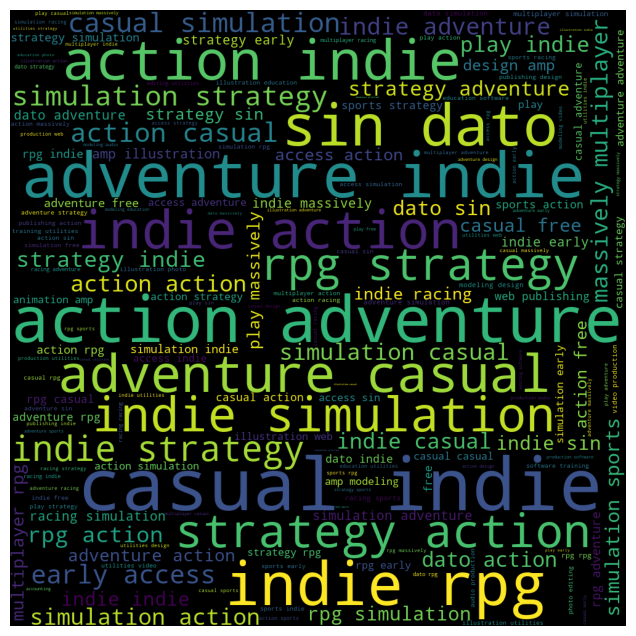

In [122]:
wordcloud = WordCloud(width=1000,height=1000).generate(nube_palabras_muestra)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Análisis de Horas Jugadas por Usuario

##### Sin Aplicar Límites:

- Al realizar este análisis, se observa que el máximo número de horas jugadas alcanza las 600,000. Esta cifra resulta sorprendente si consideramos que Steam abrió el 21 de septiembre de 2003 y la fecha máxima en la base de datos es el 31 de diciembre de 2021, lo que representa un total de 160,110 horas desde su lanzamiento. Por lo tanto, se puede concluir que los usuarios con más de 160,110 horas son considerados outliers.

##### Conclusiones:

- En resumen, la mayoría de los usuarios registran una frecuencia de juego de menos de 10,000 horas. Sin embargo, se observa una disminución significativa en la frecuencia a medida que aumentan las horas jugadas, siendo poco común encontrar usuarios con aproximadamente 15,000 horas de juego.


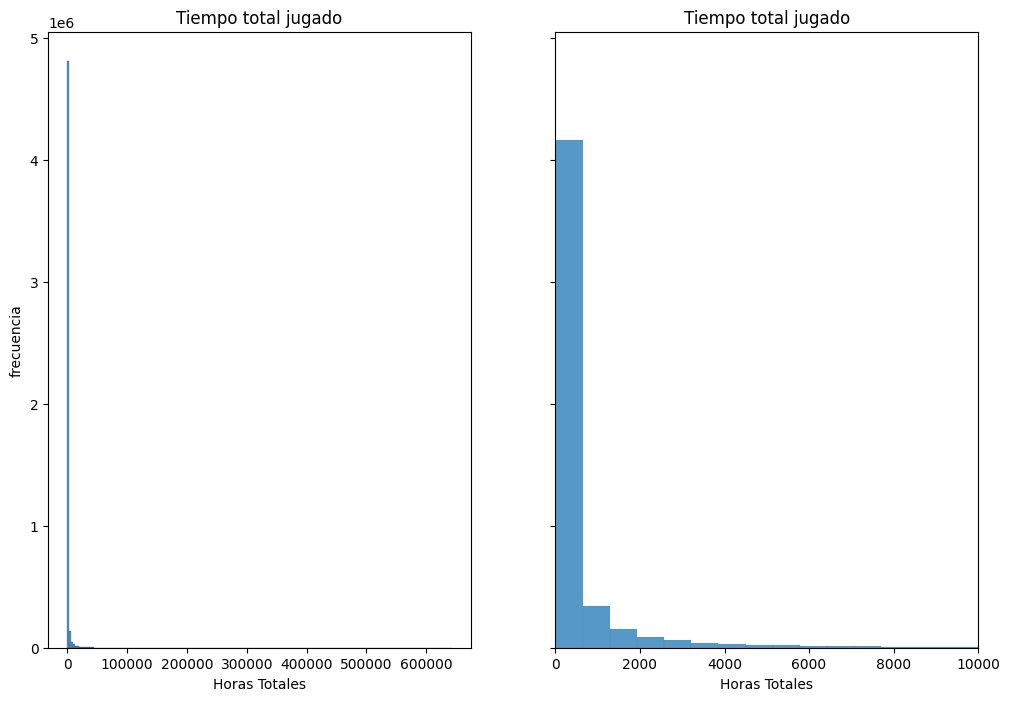

In [123]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (12,8),sharey='all')
sns.histplot(data=df_items, x='playtime_forever',bins=200,ax=ax1)
ax1.set_title('Tiempo total jugado')
ax1.set_xlabel('Horas Totales')
ax1.set_ylabel('frecuencia')

sns.histplot(data=df_items, x='playtime_forever',bins=1000,ax=ax2)
ax2.set_xlim(0,10000)
ax2.set_title('Tiempo total jugado')
ax2.set_xlabel('Horas Totales')
ax2.set_ylabel('frecuencia')
plt.show()

#### Análisis de la Distribución de Items por Usuario

##### Observaciones:

- La cantidad de items que cada usuario posee tiende a disminuir significativamente a partir del umbral de 1000.
- La mayoría de los usuarios se concentran en el rango de 0 a 1000 items.
- Aunque algunos usuarios pueden tener alrededor de 1000 juegos o más, es poco común que realmente jueguen más de 1000.
- Es probable que adquieran juegos adicionales que luego permanezcan sin jugar en su biblioteca.

##### Importancia en el Modelo de Recomendación Usuario-Item:

Este hallazgo es relevante en la construcción del modelo de recomendación usuario-item por las siguientes razones:

- **Reflejo de Actividad Real**: Indica que la cantidad de juegos adquiridos por un usuario puede no reflejar necesariamente su actividad de juego real.
- **Optimización del Modelo**: Al comprender mejor el comportamiento de los usuarios con respecto a la cantidad de juegos adquiridos y jugados, podemos optimizar el modelo de recomendación para ofrecer sugerencias más precisas y relevantes.



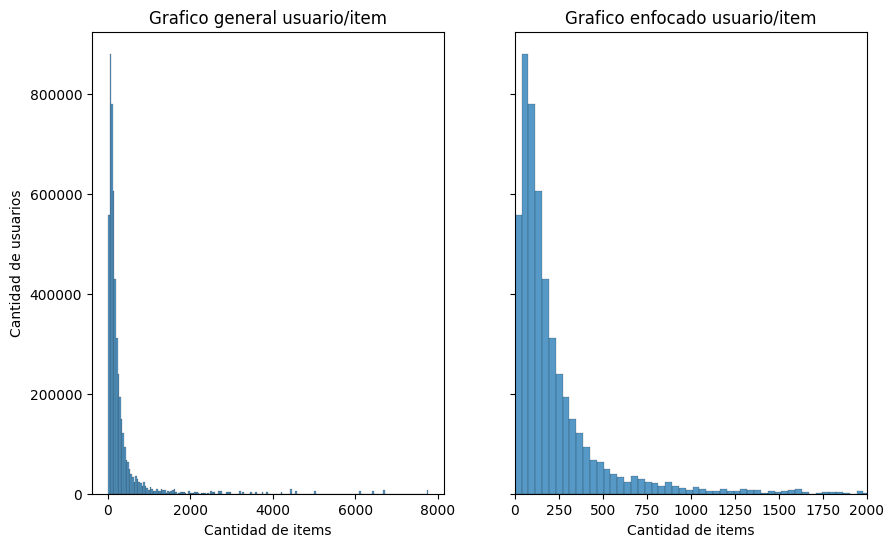

In [124]:
fig,(ax1,ax2)= plt.subplots(1,2,figsize = (10,6),sharey='all')
sns.histplot(data=df_items,x="items_count",bins=200,ax=ax1)
ax1.set_title("Grafico general usuario/item")
ax1.set_xlabel("Cantidad de items")
ax1.set_ylabel("Cantidad de usuarios")

sns.histplot(data=df_items,x="items_count",bins=200,ax=ax2)
ax2.set_title("Grafico enfocado usuario/item")
ax2.set_xlabel("Cantidad de items")
ax2.set_ylabel("Cantidad de usuarios")
ax2.set_xlim(0,2000)
plt.show()

#### Análisis del Gráfico de Compras de Juegos

En base a este gráfico, se observa que la mayoría de las compras de juegos se concentran en el período de 1980 a 2020. Sin embargo, también se destaca una amplia variación en años y precios entre los juegos:

- **Variación de Precios**: Se identifican juegos con precios superiores a los 200 dólares, los cuales son adquiridos por un número reducido de usuarios.
- **Año de Lanzamiento**: Aproximadamente dos juegos se registran entre 1970 y 1980.

También se detecta la presencia de juegos con datos faltantes, como aquellos que muestran 0 años y 0 precios, o aquellos con precio registrado pero sin año. Se puede inferir que los juegos con un precio de 0 son gratuitos.

Este análisis resalta la diversidad en la distribución de precios y años de lanzamiento de los juegos, así como la presencia de datos faltantes que podrían impactar en el análisis de la muestra.



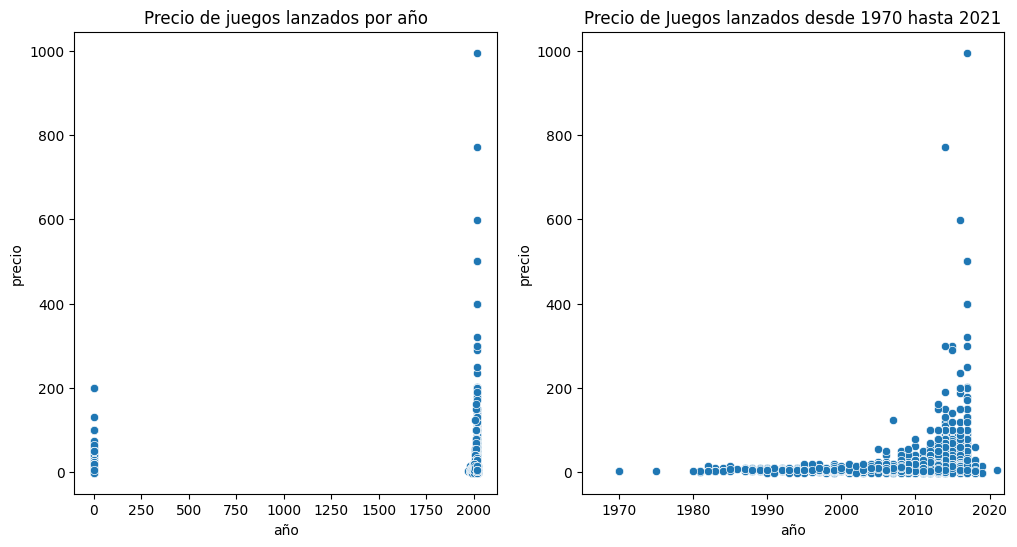

In [125]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (12,6))

# grafico general
sns.scatterplot(data=df_games,y="price",x="año",ax=ax1)
ax1.set_title("Precio de juegos lanzados por año")
ax1.set_ylabel("precio")

# grafico reducido
sns.scatterplot(data=df_games,y="price",x="año",ax=ax2)
ax2.set_title("Precio de Juegos lanzados desde 1970 hasta 2021")
ax2.set_xlim(1965,2022)
ax2.set_ylabel("precio")
plt.show()

#### Análisis del Gráfico de Recomendaciones

En base a este gráfico, observamos una gran diferencia en la cantidad de recomendaciones entre distintas categorías. Además, notamos la distribución de sentimientos en cada tipo de recomendación:

- **Sentimientos negativos en buenas recomendaciones**: Es destacable la cantidad de sentimientos negativos presentes en las buenas recomendaciones.
- **Sentimientos positivos en malas recomendaciones**: De manera inversa, observamos una cantidad significativa de sentimientos positivos en las malas recomendaciones.

Esto sugiere que el analizador de sentimientos tiene un porcentaje significativo de error, lo cual podría afectar negativamente la calidad de las recomendaciones.


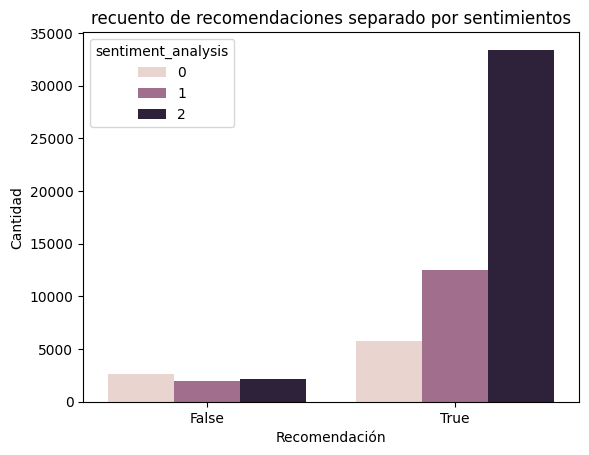

In [126]:
sns.countplot(data=df_reviews,x="recommend",hue="sentiment_analysis")
plt.title("recuento de recomendaciones separado por sentimientos")
plt.xlabel("Recomendación")
plt.ylabel("Cantidad")
plt.show()

### Conclusiones Finales:

- **Subutilización de la Biblioteca de Juegos**: Se observa que muchos usuarios tienen una gran cantidad de juegos en su biblioteca que no han sido jugados. Esto sugiere una subutilización de la biblioteca, donde algunos juegos no han sido probados, calificados ni recomendados. Este fenómeno desequilibra el dataset para el modelo de recomendación.

- **Equilibrado por Uniones de Tablas**: Se espera que este desequilibrio de datos inusuales se corrija o se evidencie más claramente la pérdida de datos cuando se realicen uniones entre las tablas de reviews, items y games, reduciendo la cantidad de juegos no jugados por usuario.

- **Horas Jugadas Inusuales**: Además, se observa que algunos usuarios han acumulado un número inusualmente alto de horas jugadas, superando las 160,110 horas. Esto podría relacionarse con el tiempo desde el lanzamiento del juego original, pero se debe tener en cuenta que se considera la plataforma de Steam en su totalidad, no solo juegos específicos.

- **Desequilibrio en Recomendaciones**: Aunque la mayoría de las recomendaciones son positivas, se observa una cantidad significativa de sentimientos negativos en las recomendaciones. Esto indica que el sistema de análisis de sentimientos podría necesitar ajustes adicionales para mejorar la precisión y el equilibrio en las recomendaciones.


### Seleccion de columnas para el modelo de Recomendacion 
* modelo de recomendacion Item-Item: para este modelo se tiene que tomar en cuenta las similitudes entre productos,recomendaciones,los comentarios positivos,neutros y negativos,la cantidad de compras de ese juego.
* modelo de recomendacion Usuario-Item: para este modelo se tienen en cuenta las coincidencias entre usuarios haciendo una agrupacion , y las recomendaciones basado a lo que le gustaron

#### Dataframe para Sistema de Recomendacion item-item

empezamos aplicando los filtros que vimos en las graficas

In [127]:
df_items = df_items[df_items["playtime_forever"] < 160000]
df_items.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5093518 entries, 0 to 5094081
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   item_id           int32  
 1   playtime_forever  float64
 2   user_id           object 
 3   items_count       int64  
 4   steam_id          object 
dtypes: float64(1), int32(1), int64(1), object(2)
memory usage: 213.7+ MB


* convertimos los np.ndarray de cada fila de genres a lista

In [128]:
df_games["genres"] = df_games["genres"].apply(conversor_a_lista)

* borramos los generos que aparescan sin dato

In [129]:
df_games = df_games[df_games["genres"] != "sin dato"].reset_index(drop=True)
df_games

,genres,app_name,price,item_id,developer,año
0,"[Action, Casual, Indie, Simulation, Strategy]",lost summoner kitty,4.99,761140,kotoshiro,2018
1,"[Free to Play, Indie, RPG, Strategy]",ironbound,0.00,643980,secret level srl,2018
2,"[Casual, Free to Play, Indie, Simulation, Sports]",real pool 3d - poolians,0.00,670290,poolians.com,2017
3,"[Action, Adventure, Casual]",弹炸人2222,0.99,767400,彼岸领域,2017
4,"[Action, Adventure, Simulation]",battle royale trainer,3.99,772540,trickjump games ltd,2018
...,...,...,...,...,...,...
28842,"[Action, Adventure, Casual, Indie]",kebab it up!,1.99,745400,bidoniera games,2018
28843,"[Casual, Indie, Simulation, Strategy]",colony on mars,1.99,773640,"nikita ""ghost_rus""",2018
28844,"[Casual, Indie, Strategy]",logistical: south africa,4.99,733530,sacada,2018
28845,"[Indie, Racing, Simulation]",russian roads,1.99,610660,laush dmitriy sergeevich,2018


* procedemos a separar la lista y que genere una fila por usuario donde tenga cada genero de ese usuario
* luego a esos generos lo convertimos a minuscula

In [130]:
df_games[df_games["genres"] != "sin dato"]
genres_expandido = df_games.explode("genres")
genres_expandido["genres"] = genres_expandido["genres"].str.lower()
genres_expandido

,genres,app_name,price,item_id,developer,año
0,action,lost summoner kitty,4.99,761140,kotoshiro,2018
0,casual,lost summoner kitty,4.99,761140,kotoshiro,2018
0,indie,lost summoner kitty,4.99,761140,kotoshiro,2018
0,simulation,lost summoner kitty,4.99,761140,kotoshiro,2018
0,strategy,lost summoner kitty,4.99,761140,kotoshiro,2018
...,...,...,...,...,...,...
28845,indie,russian roads,1.99,610660,laush dmitriy sergeevich,2018
28845,racing,russian roads,1.99,610660,laush dmitriy sergeevich,2018
28845,simulation,russian roads,1.99,610660,laush dmitriy sergeevich,2018
28846,casual,exit 2 - directions,4.99,658870,"xropi,stev3ns",2017


* creamos un nuevo dataframes donde esté los dummis

In [131]:
dummies = pd.get_dummies(genres_expandido["genres"])
dummies

,accounting,action,adventure,animation &amp; modeling,audio production,casual,design &amp; illustration,early access,education,free to play,...,photo editing,racing,rpg,simulation,software training,sports,strategy,utilities,video production,web publishing
0,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28845,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
28845,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
28845,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
28846,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


* agrupamos los dummis por el index

In [132]:
dummies = dummies.groupby(level=0).sum().reset_index(drop=True)
dummies

,accounting,action,adventure,animation &amp; modeling,audio production,casual,design &amp; illustration,early access,education,free to play,...,photo editing,racing,rpg,simulation,software training,sports,strategy,utilities,video production,web publishing
0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
3,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28842,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28843,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
28844,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
28845,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0


* unimos la tabla de games con la de dummis y borramos las columnas no necesarias para posteriormente unirlo con otra tabla

In [133]:
df_final_dummies = pd.concat([df_games,dummies],axis=1)
df_final_dummies.drop(["genres","app_name","price","developer","año"],axis=1,inplace=True)
df_final_dummies

,item_id,accounting,action,adventure,animation &amp; modeling,audio production,casual,design &amp; illustration,early access,education,...,photo editing,racing,rpg,simulation,software training,sports,strategy,utilities,video production,web publishing
0,761140,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,643980,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,670290,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,767400,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,772540,0,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28842,745400,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28843,773640,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
28844,733530,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
28845,610660,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0


* hacemos la vision de la tabla reviews

In [134]:
df_reviews.head(5)

,user_id,item_id,recommend,sentiment_analysis
0,76561197970982479,1250,True,2
1,76561197970982479,22200,True,2
2,76561197970982479,43110,True,2
3,js41637,251610,True,2
4,js41637,227300,True,2


* vamos a intentar unir las tablas por usuarios ya que hay usuarios que compraron o jugaron que talves no hayan dado una opinion sobre el juego, a los que no opinaron van a estar con None en recommend y con 1 en el analsis de sentimientos

In [135]:
union_reviews_items = pd.merge(df_reviews,df_items,on=["user_id","item_id"],how="right")

In [136]:
union_reviews_items

,user_id,item_id,recommend,sentiment_analysis,playtime_forever,items_count,steam_id
0,76561197970982479,10,NaN,NaN,6.0,277,76561197970982479
1,76561197970982479,20,NaN,NaN,0.0,277,76561197970982479
2,76561197970982479,30,NaN,NaN,7.0,277,76561197970982479
3,76561197970982479,40,NaN,NaN,0.0,277,76561197970982479
4,76561197970982479,50,NaN,NaN,0.0,277,76561197970982479
...,...,...,...,...,...,...,...
5093513,76561198329548331,346330,NaN,NaN,0.0,7,76561198329548331
5093514,76561198329548331,373330,NaN,NaN,0.0,7,76561198329548331
5093515,76561198329548331,388490,NaN,NaN,3.0,7,76561198329548331
5093516,76561198329548331,521570,NaN,NaN,4.0,7,76561198329548331


vamos a hacer dos uniones para hacer el dataframe para el sistema de recomendacion Item-Item
* la primera va a ser la de games con reviews, para obtener los usuarios que recomendaron y opinaron sobre el juego
* la segunda es la tabla de dummies de cada juego

* borramos la columna de usuario ya que no lo vamos a utilizar

In [137]:
df_reviews_simplificado = union_reviews_items.drop(columns=["playtime_forever","items_count","steam_id"],axis=1)
df_reviews_simplificado

,user_id,item_id,recommend,sentiment_analysis
0,76561197970982479,10,NaN,NaN
1,76561197970982479,20,NaN,NaN
2,76561197970982479,30,NaN,NaN
3,76561197970982479,40,NaN,NaN
4,76561197970982479,50,NaN,NaN
...,...,...,...,...
5093513,76561198329548331,346330,NaN,NaN
5093514,76561198329548331,373330,NaN,NaN
5093515,76561198329548331,388490,NaN,NaN
5093516,76561198329548331,521570,NaN,NaN


* copiamos el dataframe games para no alterar nada si lo queremos volver a utilizar y ahora borramos generos y precio

In [138]:
df_games_1 = df_games.copy()
df_games_1.drop(columns=["genres","price"],inplace=True)
df_games_1

,app_name,item_id,developer,año
0,lost summoner kitty,761140,kotoshiro,2018
1,ironbound,643980,secret level srl,2018
2,real pool 3d - poolians,670290,poolians.com,2017
3,弹炸人2222,767400,彼岸领域,2017
4,battle royale trainer,772540,trickjump games ltd,2018
...,...,...,...,...
28842,kebab it up!,745400,bidoniera games,2018
28843,colony on mars,773640,"nikita ""ghost_rus""",2018
28844,logistical: south africa,733530,sacada,2018
28845,russian roads,610660,laush dmitriy sergeevich,2018


* hacemos la union de games con reviews para posteriormente unirlo con dummies

In [139]:
vista = pd.merge(df_games_1,df_reviews_simplificado,on="item_id",how="left")

* hacemos la agrupacion de los datos por item_id,nombre del juego, developer, año y hacemos calculos de agregacion de recomendaciones,comentarios y juegos vendidos

In [140]:
df_games_reviews = vista.groupby(by=["item_id","app_name","developer","año"]).agg(
    recomendados_positivos = ("recommend",lambda x : (x == True).sum()),
    recomendados_negativos = ("recommend",lambda x : (x == False).sum()),
    comentarios_positivos = ("sentiment_analysis",lambda x: (x == 2).sum()),
    comentarios_neutros = ("sentiment_analysis",lambda x: (x == 1).sum()),
    comentarios_negativos = ("sentiment_analysis",lambda x: (x == 0).sum()),
    juegos_vendidos = ("item_id","sum")
).reset_index()
df_games_reviews

,item_id,app_name,developer,año,recomendados_positivos,recomendados_negativos,comentarios_positivos,comentarios_neutros,comentarios_negativos,juegos_vendidos
0,10,counter-strike,valve,2000,44,1,29,16,0,96040
1,20,team fortress classic,valve,1999,10,5,9,4,2,125360
2,30,day of defeat,valve,2003,3,1,3,1,0,102930
3,40,deathmatch classic,valve,2001,1,0,1,0,0,129680
4,50,half-life: opposing force,gearbox software,1999,2,1,3,0,0,310800
...,...,...,...,...,...,...,...,...,...,...
28842,2028055,tom clancy's ghost recon future soldier - seas...,"ubisoft paris,red storm entertainment",2012,0,0,0,0,0,2028055
28843,2028056,worms revolution season pass,team17 digital ltd.,2012,0,0,0,0,0,2028056
28844,2028062,call of duty®: black ops ii season pass,treyarch,0,0,0,0,0,0,2028062
28845,2028103,assassin’s creed® iii season pass,ubisoft montreal,2012,0,0,0,0,0,2028103


* hacemos la union final de las tablas para luego exportarlo

In [141]:
df_final_items_dummies = pd.merge(df_games_reviews,df_final_dummies,on="item_id")
df_final_items_dummies.head(5)

,item_id,app_name,developer,año,recomendados_positivos,recomendados_negativos,comentarios_positivos,comentarios_neutros,comentarios_negativos,juegos_vendidos,...,photo editing,racing,rpg,simulation,software training,sports,strategy,utilities,video production,web publishing
0,10,counter-strike,valve,2000,44,1,29,16,0,96040,...,0,0,0,0,0,0,0,0,0,0
1,20,team fortress classic,valve,1999,10,5,9,4,2,125360,...,0,0,0,0,0,0,0,0,0,0
2,30,day of defeat,valve,2003,3,1,3,1,0,102930,...,0,0,0,0,0,0,0,0,0,0
3,40,deathmatch classic,valve,2001,1,0,1,0,0,129680,...,0,0,0,0,0,0,0,0,0,0
4,50,half-life: opposing force,gearbox software,1999,2,1,3,0,0,310800,...,0,0,0,0,0,0,0,0,0,0


* por ultimo vamos a calcular la valoracion de cada juego y borrar las columnas que ya no hagan falta, para posteriormente recomendarlo

In [142]:
df_final_items_dummies["Valoración"] = Valoraciones(df_final_items_dummies["recomendados_positivos"],df_final_items_dummies["recomendados_negativos"],
                                                    df_final_items_dummies["comentarios_positivos"],df_final_items_dummies["comentarios_neutros"],
                                                    df_final_items_dummies["comentarios_negativos"])
df_final_items_dummies["Valoración"] = df_final_items_dummies["Valoración"].fillna(3.0)
df_final_items_dummies['Valoración'] = df_final_items_dummies['Valoración'].apply(lambda x: 0 if x < 0 else x)
df_final_items_dummies = df_final_items_dummies.drop(columns=["recomendados_positivos","recomendados_negativos","comentarios_positivos","comentarios_neutros","comentarios_negativos"])


* revisamos como quedó la tabla. y vemos que quedó perfecto

In [143]:
df_final_items_dummies

,item_id,app_name,developer,año,juegos_vendidos,accounting,action,adventure,animation &amp; modeling,audio production,...,racing,rpg,simulation,software training,sports,strategy,utilities,video production,web publishing,Valoración
0,10,counter-strike,valve,2000,96040,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,4.2
1,20,team fortress classic,valve,1999,125360,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2.7
2,30,day of defeat,valve,2003,102930,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3.5
3,40,deathmatch classic,valve,2001,129680,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,5.0
4,50,half-life: opposing force,gearbox software,1999,310800,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28842,2028055,tom clancy's ghost recon future soldier - seas...,"ubisoft paris,red storm entertainment",2012,2028055,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3.0
28843,2028056,worms revolution season pass,team17 digital ltd.,2012,2028056,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,3.0
28844,2028062,call of duty®: black ops ii season pass,treyarch,0,2028062,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3.0
28845,2028103,assassin’s creed® iii season pass,ubisoft montreal,2012,2028103,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,3.0


* borramos las columnas las columnas que no vamos a hacer y lo guardamos en un nuevo dataframe para ver la correlativas

In [144]:
df_correlativa = df_games_reviews.drop(columns=["item_id","app_name","developer","año"])

* entre lo ultimo vemos la correlativas de games y reviews

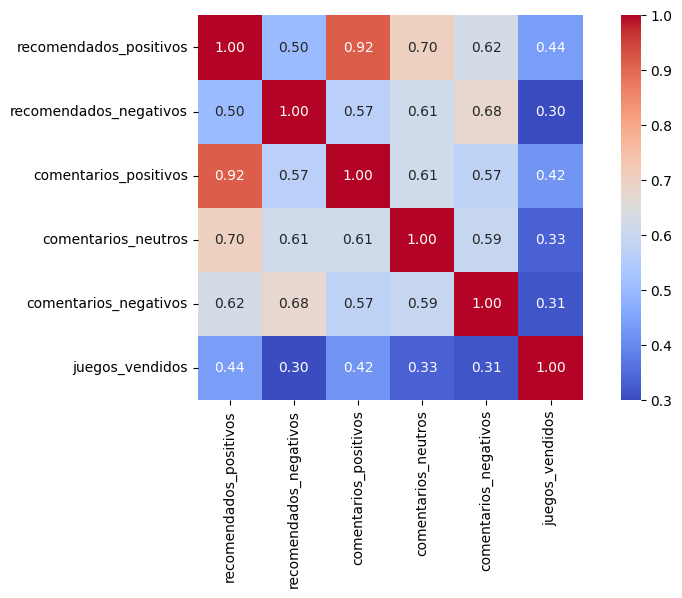

In [145]:
plt.figure(figsize=(10,5)) 
sns.heatmap(df_correlativa.corr(method=("spearman")), cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 10},cmap= 'coolwarm')
plt.show()

* bajo este analisis podemos decir que la mayoria de los juegos vendidos son con recomendaciones y opiniones positivas. y la mayoria de las opiniones está correlacionado con una buena recomendacion

#### Dataframe para sistema de recomendacion usuario-item


* vamos a volver a utilizar la tabla unida entre reviews y items ya que tiene la correción de las horas jugadas y tambien todos los juegos que tienen los usuarios

In [146]:
df_reviews_simplificado

,user_id,item_id,recommend,sentiment_analysis
0,76561197970982479,10,NaN,NaN
1,76561197970982479,20,NaN,NaN
2,76561197970982479,30,NaN,NaN
3,76561197970982479,40,NaN,NaN
4,76561197970982479,50,NaN,NaN
...,...,...,...,...
5093513,76561198329548331,346330,NaN,NaN
5093514,76561198329548331,373330,NaN,NaN
5093515,76561198329548331,388490,NaN,NaN
5093516,76561198329548331,521570,NaN,NaN


* borramos los Nulos ya que vamos a querer solo los que si opinaron y recomendaron

In [147]:
df_reviews_simplificado = df_reviews_simplificado.dropna()

* borramos la caolumna de recomendacion y analisis de sentimientos ya que tenemos los que si opinaron

In [148]:
df_reviews_simplificado = df_reviews_simplificado.drop(columns=["recommend","sentiment_analysis"],axis=1)

* hacemos una vista de como quedó

In [149]:
df_reviews_simplificado

,user_id,item_id
44,76561197970982479,22200
46,76561197970982479,1250
82,76561197970982479,43110
587,js41637,227300
661,js41637,239030
...,...,...
5092890,ghoustik,730
5092919,76561198312638244,70
5092920,76561198312638244,130
5092941,76561198312638244,233270


* mirando los dataframes a utilizar, no va a hacer falta sacar los dummies nuevamente ya que lo hicimos anteriormente y lo dejamos por item_id

In [150]:
df_final_dummies

,item_id,accounting,action,adventure,animation &amp; modeling,audio production,casual,design &amp; illustration,early access,education,...,photo editing,racing,rpg,simulation,software training,sports,strategy,utilities,video production,web publishing
0,761140,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,643980,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,670290,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,767400,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,772540,0,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28842,745400,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28843,773640,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
28844,733530,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
28845,610660,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0


* hacemos la agrupacion de las tablas de dummies y de reviews_simplificado

In [151]:
df_recomendacion_usuario_item = pd.merge(df_reviews_simplificado,df_final_dummies,on="item_id")

* agrupamos por usuario y guardamos los generos que jugó y le gustan

In [152]:
df_recomendacion_usuario_item.groupby(["user_id","item_id"]).max().reset_index()

,user_id,item_id,accounting,action,adventure,animation &amp; modeling,audio production,casual,design &amp; illustration,early access,...,photo editing,racing,rpg,simulation,software training,sports,strategy,utilities,video production,web publishing
0,--000--,1250,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,--ace--,113200,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,--ionex--,730,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,--ionex--,105600,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,-2sv-vulb-kg,730,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38358,zyr0n1c,8980,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
38359,zyr0n1c,17470,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38360,zyr0n1c,208090,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38361,zyr0n1c,230410,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Exportacion de Archivos para Modelos de Recomendación

* Exportamos el Dataframe para hacer el sistema de Recomendacion item-item

In [153]:
df_final_items_dummies.to_parquet("Datasets_endpoints/recommend_item_item.parquet",compression="brotli")

* Exportamos para el modelo de recomendacion usuario-item

In [154]:
df_recomendacion_usuario_item.to_parquet("Datasets_endpoints/recommend_usuario_item.parquet",compression="brotli")